# Get them adopted

![Austin-shelter](http://www.austintexas.gov/sites/default/files/aac_logo.jpg)

## Business question:

Austin, Texas is the largest No Kill community in the nation, and home to the Austin Animal Center. They provide shelter to more than 16,000 animals each year and animal protection and pet resource services to all of Austin and Travis County. Annually over 90% of animals entering the center, are adopted, transferred to rescue or returned to their owners.

The Austin Animal Center _also_ has the longest running public dataset of animal rescues in the country. Every animal has a unique id that ties to both their [intake](https://data.austintexas.gov/Health-and-Community-Services/Austin-Animal-Center-Intakes/wter-evkm) and [outcome](https://data.austintexas.gov/Health-and-Community-Services/Austin-Animal-Center-Outcomes/9t4d-g238) data when they enter and leave the shelter. Given their data, my questions of interest were:

- What animals need a PR campaign?
- What resources does the Animal Center need?

Analyzing the Austin Animal Center data to answer these questions will assist their mission an improve operations. 

### Defining "Needing PR campaign" as animals that take the longest time to get adopted, or have the fewest transfers to rescue partners.
![img](./images/animals.png)


### For resources, I chose to focus on factors that would impact **cost** and _staffing_:
- breed/specialization of staff
- funds for neutering animals
- average stay of animals - would impact resources needed (food, cleaning, space)
- condition of animals when they enter the shelter
- percent of "special needs" animals - babies/seniors

![img2](./images/pet-resource-center-og.jpg)

### Data

(need to fill in)
- no nas
- since 2013
- NUMBER OF ANIMALS
- SUMMARY OF COLUMNS AND THEIR MEANING

### Methods

### Import packages and process data

`data_cleaning` and `feature_engineering` are packages made to store the functions and code used to prepare the data in seperate namespaces. 

In [112]:
import pandas as pd
import numpy as np
import code_folder.data_cleaning as dc
import code_folder.feature_engineering as fe
import code_folder.visualizations_graphs as viz_g
import code_folder.visualizations_tables as viz_t

pd.options.display.max_columns = 999
pd.options.display.max_rows = 999

# %load_ext autoreload
# %autoreload 2


In [3]:
outcomes = pd.read_csv('https://data.austintexas.gov/api/views/9t4d-g238/rows.csv?accessType=DOWNLOAD')
intakes = pd.read_csv('https://data.austintexas.gov/api/views/wter-evkm/rows.csv?accessType=DOWNLOAD')

#### `data_cleaning`
For each intake and outcome file, respectively addresses:
- dates not in the correct datetime format
- column names have mixed cases and spaces 
- an age variable that needs to be replaced
- unnecessary columns tht can be dropped
- create some additional date variables to help merge later

Before merging the datasets to create a record for each animal's stay each year. Length of stay can then be created by comparing the intake and outcome dates.

In [4]:
outcomes = dc.prep_outcomes_file(outcomes)
intakes = dc.prep_intakes_file(intakes)
animal_shelter_df = dc.merge_files(intakes,outcomes)

#### `feature_engineering`

In [5]:
animal_shelter_df = fe.create_species_var(animal_shelter_df)
animal_shelter_df = fe.create_neutered_var(animal_shelter_df)
animal_shelter_df = fe.reduce_breed_list(animal_shelter_df)

In [ ]:
animal_shelter_df.to_csv('./data/cleaned_animal_center_df.csv')

#### Create appropriate level of granularity for animal species and breed.

Exploritory analysis revealed that the two variables that describe the "type" of animal were `animal_type` and `breed`.

`animal_type` has five values: Dog, Cat, Bird, Livestock, and Other.

While `animal_type`s Cat and Dog were straight forward, "Other" appeared to hold a mix of species - both pets and wildlife. 

Within "Other" there is a lot of fuzzy matching within the breed variable.

![breeds](./images/breeds_i.png)

For example "Rabbit" and "Guinea Pig" each had repeat entries. To find a middle ground, I created the function `create_species_var` to map and aggregate the `breed` and `intake_type` to provide more insight into the types of animals the shelter services.

I then used my function `reduced_breed_list` to remov "mix" from many of the cat and dog breeds. This allowed "Domestic Shorthair Mix" cats to be counted along with "Domestic Shorthair" and the same with "German Shepard Mix" being count as a "German Shepard."

I've chosen not to analyze livestock, as there are only 12 of them in the dataset.

#### A deep look at neutering

Neutering of animals at the Austin Animal Center is funded by [The City of Austin and Travis County](https://www.austintexas.gov/page/no-kill-plan), but how many neuterings are they doing a month? Is that number increasing  or decreasing? By comparing the variables `sex_upon_intake` and `sex_upon_outcome` for each animal, a change in status from "intact" to "neutered" reveals the animal was neutered during their stay at the Rescue Center.

#### Revisit our questions

- Age of animals in shelter
- Average animal length of stay
- Medical staff needed

In [33]:
## Creates table visualizations
viz_t.value_counts_table(animal_shelter_df.species.value_counts().append(pd.Series(animal_shelter_df.shape[0], index=["Total"])), "Animal Intake since 2013", "species_i")
viz_t.value_counts_table(animal_shelter_df.loc[animal_shelter_df.year==2019].species.value_counts().append(pd.Series(animal_shelter_df.loc[animal_shelter_df.year==2019].shape[0], index=["Total"])), "Animal Intake since 2013", "intake_2019")

In [34]:
## Creates time series graohs of intakes by animal species/type

# Get intake count of cats and dogs over time
summed_df = animal_shelter_df.loc[(animal_shelter_df['species'].str.contains("Dog|Cat"))].groupby([pd.Grouper(key="date_i",freq='1M'), 'species']).count()\
                .reset_index().pivot(index='date_i', columns='species', values='animal_id')
viz_g.time_series_plot(summed_df,"Seasonal Intake patterns of Cats and Dogs","Date by Month","Intake Count","intake_cat_dog",100)

# Get intake count of wildlife over time
summed_wildlife = animal_shelter_df.loc[(animal_shelter_df['species'].str.contains("Wildlife"))].groupby([pd.Grouper(key="date_i",freq='1M'), 'species']).count()\
                .reset_index().pivot(index='date_i', columns='species', values='animal_id')
viz_g.time_series_plot(summed_wildlife,"Intake patterns of Wildlife","Date by Month","Intake Count",'wildlife_count',10)

# Get intake count of all others over time
summed_df_small_b = animal_shelter_df.loc[(~animal_shelter_df['species'].str.contains("Dog|Cat|Wildlife"))].groupby([pd.Grouper(key="date_i",freq='1M'), 'species']).count()\
                .reset_index().pivot(index='date_i', columns='species', values='animal_id')
viz_g.time_series_plot(summed_df_small_b,"Intake patterns of Animals that aren't Cats or Dogs","Date by Month","Intake Count",'other_species_count',10)

# Highlight history of Chickens, Rabbits, and Guinea Pigs over time
summed_df_small_pets = animal_shelter_df.loc[(animal_shelter_df['species'].str.contains("Chicken|Rabbit|Guinea"))].groupby([pd.Grouper(key="date_i",freq='1M'), 'species']).count()\
                .reset_index().pivot(index='date_i', columns='species', values='animal_id')
viz_g.time_series_plot(summed_df_small_pets,"Intake History of Chickens, Rabbits, and Guinea Pigs","Date by Month","Intake Count",'small_pet_count',5)

<Figure size 1280x800 with 0 Axes>

<Figure size 1280x800 with 0 Axes>

<Figure size 1280x800 with 0 Axes>

<Figure size 1280x800 with 0 Axes>

In [60]:
test = animal_shelter_df.loc[(animal_shelter_df['species'].str.contains("Dog|Cat")) & (animal_shelter_df.neutered ==1)].groupby([pd.Grouper(key="date_i",freq='1M'), 'species']).count()\
                .reset_index().pivot(index='date_i', columns='species', values='animal_id')

test.columns = ['Cat_neutered', "Dog_neutered"]

test2 = pd.concat([summed_df, test], axis=1)

test2['percent_cat'] = test2.Cat_neutered/test2.Cat
test2['percent_dog'] = test2.Dog_neutered/test2.Dog
test2.drop(columns = ['Cat', 'Dog', 'Cat_neutered', 'Dog_neutered'], inplace = True)
test2.columns = ['Cat', 'Dog']


In [77]:
viz_g.time_series_plot_percent(test2,"History of Percent Neutered at Intake" ,"Date by Month","Percent Neutered","neutered_over_time2", 0.05)

<Figure size 1280x800 with 0 Axes>

## Animal Intake Overall

| ![all3](./images/species_i.png) | ![2019a](./images/intake_2019.png)

## Animal Intake Trends

![one](./images/intake_cat_dog.png) 
![two](./images/wildlife_count.png)
![three](./images/other_species_count.png)


### Only non-seasonal pattern
![foura](./images/small_pet_count.png)

## Neutering patterns

![neut](./images/neutered_over_time2.png)

## Medical Staffing needs:

### Findings: 

### Intake Patterns:
- The intake of cats and dogs seems to have a seasonal pattern that remains relatively constant
- Wildlife also seems fairly seasonal, with perhaps a slight downward trend since 2017
- For those animals who have seasonal patterns, winter is a low time for all
- Rabbits, chickens, and guinea pigs do not appear to have a seasonal patter
- Rabbits, chickens, and guinea pigs *do* appear to have sudden spikes

### Neutering:
- about 30-55% of cats who come in are neutered during their stay
- about 40-55% of dogs who come in are neutered during their stay, smaller variance than cats

### Comparison of Outcomes for Neutered vs Intact

In [139]:
# Get percent intact
intact_count = animal_shelter_df.loc[(animal_shelter_df.species.str.contains("Dog|Cat")) & (animal_shelter_df.sex_upon_outcome.str.contains("Intact"))].outcome_type.value_counts(normalize=True).sort_index()
intact_count.name = "percent_intact"

# Get percent neutered
neutered_count = animal_shelter_df.loc[(animal_shelter_df.species.str.contains("Dog|Cat"))&(animal_shelter_df.sex_upon_outcome.str.contains("Neutered|Spayed"))].outcome_type.value_counts(normalize=True).sort_index()
neutered_count.name = "percent_neutered"

# Create nice table
viz_t.df_table_percents(compare_neuter_outcome, "Percent Outcome Type for Dogs and Cats ", "cat_dog_neut_outcomes2")

![catdogneut2](./images/cat_dog_neut_outcomes2.png)

In [138]:
# Get percent intact
intact_count = animal_shelter_df.loc[(animal_shelter_df.species=="Dog") & (animal_shelter_df.sex_upon_outcome.str.contains("Intact"))].outcome_type.value_counts(normalize=True).sort_index()
intact_count.name = "percent_intact"

# Get percent neutered
neutered_count = animal_shelter_df.loc[(animal_shelter_df.species=="Dog")&(animal_shelter_df.sex_upon_outcome.str.contains("Neutered|Spayed"))].outcome_type.value_counts(normalize=True).sort_index()
neutered_count.name = "percent_neutered"

# Combine into one df
compare_neuter_outcome = pd.DataFrame(data={"Intact":intact_count,"Neutered":neutered_count})

# Create nice table
viz_t.df_table_percents(compare_neuter_outcome, "Percent Outcome Type for Dogs", "dog_neut_outcomes7")

![dogneu7](./images/dog_neut_outcomes7.png)

In [140]:
# Get percent intact
intact_count = animal_shelter_df.loc[(animal_shelter_df.species=="Cat") & (animal_shelter_df.sex_upon_outcome.str.contains("Intact"))].outcome_type.value_counts(normalize=True).sort_index()
intact_count.name = "percent_intact"

# Get percent neutered
neutered_count = animal_shelter_df.loc[(animal_shelter_df.species=="Cat")&(animal_shelter_df.sex_upon_outcome.str.contains("Neutered|Spayed"))].outcome_type.value_counts(normalize=True).sort_index()
neutered_count.name = "percent_neutered"

# Combine into one df
compare_neuter_outcome = pd.DataFrame(data={"intact":intact_count,"neutered":neutered_count})

# Create nice table
viz_t.df_table_percents(compare_neuter_outcome, "Percent Outcome Type for Cats", "cat_neut_outcomes2")

![catneut2](./images/cat_neut_outcomes2.png)

In [144]:
test = animal_shelter_df.loc[(animal_shelter_df.species=="Dog") &(animal_shelter_df.year==2019) & (animal_shelter_df.outcome_type =="Adoption")]

In [150]:
breeds_sub = test.breed.value_counts()[:15]

In [152]:
breed_list = breeds_sub.index.to_list()

In [155]:
test.loc[test.breed.isin(breed_list)]

,age,animal_id,animal_type,breed,color,date_i,date_o,days_in_shelter,dob,found_location,intake_condition,intake_type,month_i,month_o,monthyear,name_intake,name_outcome,outcome_subtype,outcome_type,sex_upon_intake,sex_upon_outcome,weekday_i,weekday_o,year,years_old,species,neutered
22,917 days,A754715,Dog,Labrador Retriever,Black/White,2019-07-29,2019-08-15,17,2017-02-09,Austin (TX),Normal,Owner Surrender,7,8.0,08/15/2019 01:42:00 PM,Rheia,Rheia,NaN,Adoption,Spayed Female,Spayed Female,0,3.0,2019,2.512329,Dog,0
73,2801 days,A760116,Dog,German Shepherd,Brown/Black,2019-01-07,2019-01-10,3,2011-05-11,Austin (TX),Normal,Owner Surrender,1,1.0,01/10/2019 07:20:00 PM,Jasmine,Jasmine,NaN,Adoption,Spayed Female,Spayed Female,0,3.0,2019,7.673973,Dog,0
74,2831 days,A760116,Dog,German Shepherd,Brown/Black,2019-01-07,2019-02-09,33,2011-05-11,Austin (TX),Normal,Owner Surrender,1,2.0,02/09/2019 01:14:00 PM,Jasmine,Jasmine,NaN,Adoption,Spayed Female,Spayed Female,0,5.0,2019,7.756164,Dog,0
133,1401 days,A787448,Dog,Labrador Retriever,Brown Tiger/White,2019-04-01,2019-11-14,227,2016-01-13,12900 Dessau in Travis (TX),Normal,Stray,4,11.0,11/14/2019 12:59:00 PM,Watermelon,Watermelon,NaN,Adoption,Intact Female,Spayed Female,0,3.0,2019,3.838356,Dog,1
159,94 days,A799428,Dog,Labrador Retriever,Tan/White,2019-07-08,2019-07-12,4,2019-04-09,Austin (TX),Normal,Stray,7,7.0,07/12/2019 06:31:00 PM,NaN,NaN,NaN,Adoption,Intact Male,Neutered Male,0,4.0,2019,0.257534,Dog,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133327,858 days,A792640,Dog,Pit Bull,Blue/White,2019-04-13,2019-08-19,128,2017-04-13,8502 Maine Drive in Austin (TX),Normal,Stray,4,8.0,08/19/2019 02:05:00 PM,*Lola,*Lola,NaN,Adoption,Intact Female,Spayed Female,5,0.0,2019,2.350685,Dog,1
133328,856 days,A792640,Dog,Pit Bull,Blue/White,2019-04-13,2019-08-17,126,2017-04-13,8502 Maine Drive in Austin (TX),Normal,Stray,4,8.0,08/17/2019 01:39:00 PM,*Lola,*Lola,NaN,Adoption,Intact Female,Spayed Female,5,5.0,2019,2.345205,Dog,1
133604,65 days,A794814,Dog,Border Collie,Black,2019-05-12,2019-05-16,4,2019-03-12,4550 Mueller Boulevard in Austin (TX),Normal,Stray,5,5.0,05/16/2019 06:03:00 PM,Thorium,Thorium,NaN,Adoption,Intact Male,Neutered Male,6,3.0,2019,0.178082,Dog,1
133661,144 days,A800621,Dog,Pit Bull,Red/White,2019-07-24,2019-07-31,7,2019-03-09,11417 American Mustang Loop in Manor (TX),Normal,Stray,7,7.0,07/31/2019 03:16:00 PM,*Doobie,*Doobie,NaN,Adoption,Intact Male,Neutered Male,2,2.0,2019,0.394521,Dog,1


In [142]:
import seaborn as sns#medians = df.groupby(['species'])['sepal_length'].median().values

medians= test.loc[test.breed.isin(breed_list)].groupby(['breed'])["days_in_shelter"].quantile(q=.75)
                                                       
nobs = test.loc[test.breed.isin(breed_list)]["breed"].value_counts().values
nobs = [str(x) for x in nobs.tolist()]
nobs = ["n: " + i for i in nobs]





fig = plt.figure(figsize=(10, 5), dpi=80) 

# Creates one subplot within our figure and uses the classes fig and ax
fig, ax = plt.subplots(figsize=(16, 10), dpi= 80, facecolor='w', edgecolor='k')
chart = sns.boxplot( x=test.loc[test.breed.isin(breed_list)]["breed"], y=test.loc[test.breed.isin(breed_list)]["days_in_shelter"],color='w', showfliers=False )
#ax.xaxis.set_major_locator()
plt.xticks(rotation=-90)
#ax.set_ylim(0, 100)
# Add it to the plot
pos = range(len(nobs))
for tick,label in zip(pos,ax.get_xticklabels()):
    ax.text(pos[tick], medians[tick] + 0.03, nobs[tick]
    horizontalalignment='center', size='x-small', color='black', weight='semibold')

In [176]:
#medians = df.groupby(['species'])['sepal_length'].median().values

medians= test.loc[test.breed.isin(breed_list)].groupby(['breed'])["days_in_shelter"].quantile(q=.75)
                                                       
nobs = test.loc[test.breed.isin(breed_list)]["breed"].value_counts().values
nobs = [str(x) for x in nobs.tolist()]
nobs = ["n: " + i for i in nobs]





fig = plt.figure(figsize=(10, 5), dpi=80) 

# Creates one subplot within our figure and uses the classes fig and ax
fig, ax = plt.subplots(figsize=(16, 10), dpi= 80, facecolor='w', edgecolor='k')
chart = sns.boxplot( x=test.loc[test.breed.isin(breed_list)]["breed"], y=test.loc[test.breed.isin(breed_list)]["days_in_shelter"],color='w', showfliers=False )
#ax.xaxis.set_major_locator()
plt.xticks(rotation=-90)
#ax.set_ylim(0, 100)
# Add it to the plot
pos = range(len(nobs))
for tick,label in zip(pos,ax.get_xticklabels()):
    ax.text(pos[tick], medians[tick] + 0.03, nobs[tick]
    horizontalalignment='center', size='x-small', color='black', weight='semibold')

SyntaxError: invalid syntax (<ipython-input-176-296a20a62bb9>, line 25)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 <a list of 15 Text xticklabel objects>)

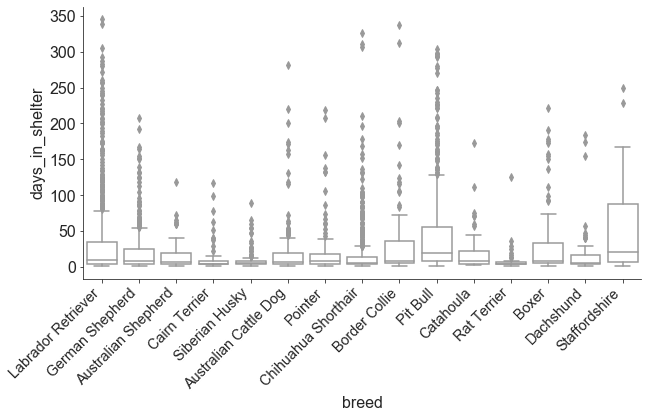

In [160]:
plt.figure(figsize=(10,5))
chart = sns.boxplot( x=test.loc[test.breed.isin(breed_list)]["breed"], y=test.loc[test.breed.isin(breed_list)]["days_in_shelter"],color='w' )

plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large'  
)


NameError: name 'fig' is not defined

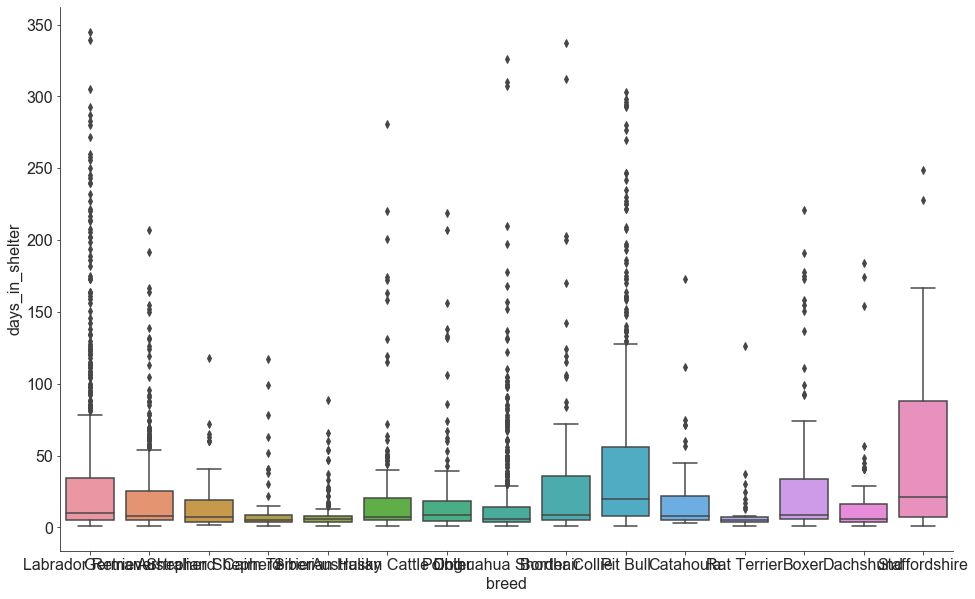

In [157]:
sns.boxplot( x=test.loc[test.breed.isin(breed_list)]["breed"], y=test.loc[test.breed.isin(breed_list)]["days_in_shelter"] )
fig.autofmt_xdate(which='both')

#sns.plt.show()

## Medical needs

1. How many animals come in injured? And what happens to them?
2. How many animals come in and over their stay get neutered?
3. Any trends in the animals that do not get neutered?

### Business Recommendations

- neutered pets get adopted at higher rates
- neutering workload is predictable - keep doing what you are doing
- while infrequent, have staff be prepared for spikes in small animal care




### Limitations

- Missing animals that came back to the shelter more than one time during a year
- Not examining animals still in the shelter
- Do not know specific costs of care or current staffing of Rescue Center
- Consistent dips in January and December might be due to how we merged the data on year, so artifical dip


### Next Steps

